In [17]:
%matplotlib widget

isdark = False

from rayoptics.environment import *

In [18]:
opm = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']

osp['pupil'] = PupilSpec(osp, key=['object', 'pupil'], value=16)
osp['fov'] = FieldSpec(osp, key=['object', 'angle'], value=1.5, flds=[0., 0.707, 1.], is_relative=True)
osp['wvls'] = WvlSpec([('F', 0.5), (587.5618, 1.0), ('C', 0.5)], ref_wl=1)

opm.radius_mode = True

sm.gaps[0].thi=1e10

sm.add_surface([246, 3, 'N-LASF9', 'Schott', 42/2])
sm.add_surface([1e9, 290+36])
gap0_idx = sm.cur_surface

sm.add_surface([1e9, 3, 'N-LASF9', 'Schott', 16/2])
sm.add_surface([-30.6, 36+36])
gap1_idx = sm.cur_surface

sm.add_surface([30.6, 3, 'N-LASF9', 'Schott', 16/2])
sm.add_surface([1e9, 36+36])
gap2_idx = sm.cur_surface

sm.add_surface([1e9, 3, 'N-LASF9', 'Schott', 16/2])
sm.add_surface([-30.6, 36])


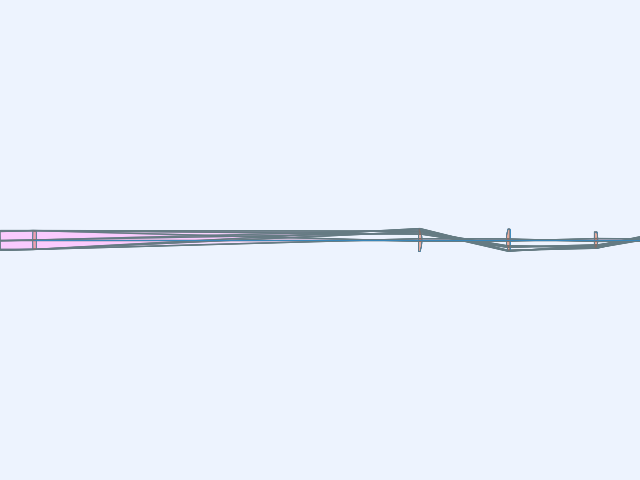

In [19]:
opm.update_model()

layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark).plot()

In [20]:
pm.first_order_data()

efl                1448
ffl          -1.193e+04
pp1          -1.048e+04
bfl               216.1
ppk                1232
f/#               90.51
m            -1.448e-07
red          -6.905e+06
obj_dist          1e+10
obj_ang             1.5
enp_dist             -0
enp_radius            8
na obj            8e-10
n obj                 1
img_dist          216.1
img_ht            37.92
exp_dist          220.5
exp_radius        0.971
na img        -0.005524
n img                 1
optical invariant       0.2095


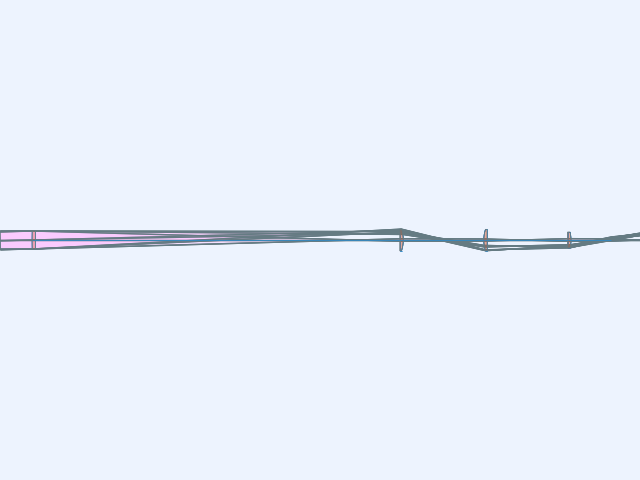

In [21]:
# add a focusing mirror
sm.insert_surface_and_gap()
cur = sm.cur_surface
sm.ifcs[cur] = ThinLens(power=1/30.)
sm.gaps[cur].thi = 30.

opm.update_model()

opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl
opm.update_model()

layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark).plot()

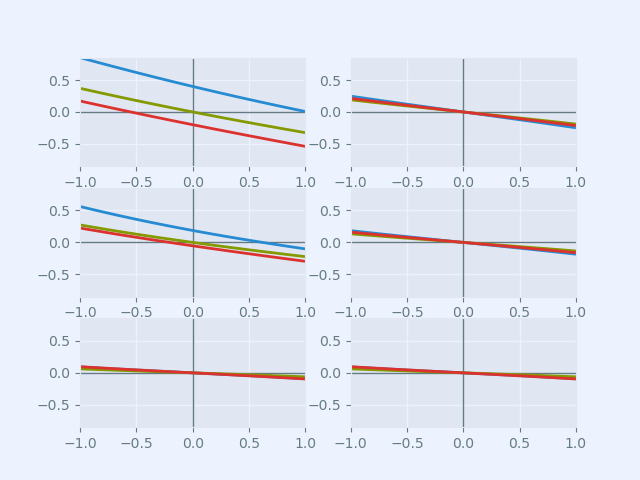

In [22]:
#spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
#                      user_scale_value=0.1, is_dark=isdark).plot()
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray',
                     scale_type=Fit.All_Same).plot()

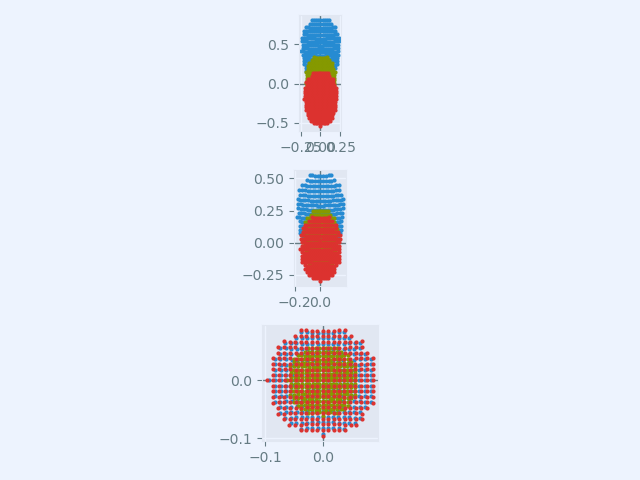

In [23]:
opm.seq_model.gaps[-1].thi = opm.optical_spec.parax_data.fod.bfl
opm.update_model()

#spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
#                      user_scale_value=0.1, is_dark=isdark).plot()T
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()

In [24]:
# hey it's me from the future, I made these functions

import rayoptics.optical.model_constants as mc

def dump_dist(p, wi, ray_pkg, fld, wvl, foc):
    if ray_pkg is not None:
        image_pt = fld.ref_sphere[0]
        ray = ray_pkg[mc.ray]
        dist = foc / ray[-1][mc.d][2]
        defocused_pt = ray[-1][mc.p] + dist*ray[-1][mc.d]
        t_abr = defocused_pt - image_pt
        return np.sqrt(np.sum(t_abr*t_abr))
    
def spot_rms(sm, fld_idx=0):
    return np.sqrt(np.mean(np.square(sm.trace_grid(dump_dist, fld_idx, form='list', append_if_none=False)[0]), axis=1))

def dump_rays(p, wi, ray_pkg, fld, wvl, foc):
    if ray_pkg is not None:
        image_pt = fld.ref_sphere[0]
        ray = ray_pkg[mc.ray]
        v = ray[-1][mc.d][0:2] / ray[-1][mc.d][2]
        return [ray[-1][mc.p][0:2] - image_pt[0:2], v]
    
def get_focus(sm, offset=False, weights=np.array([0.25, 0.5, 0.25])):
    offsets = np.linspace(-40, 40, 2000)
    vals, colors = sm.trace_grid(dump_rays, 0, form='list', append_if_none=False)

    rms = np.zeros((offsets.size, len(vals)), dtype=float)

    for i in range(offsets.size):
        for j in range(len(vals)):
            rms[i][j] = np.sqrt(np.mean(np.square(vals[j][:,0]+vals[j][:,1]*offsets[i])))

    if offset:
        return offsets[np.argmin(np.sum(rms*weights, axis=1))]
    else:
        return sm.gaps[-1].thi + offsets[np.argmin(np.sum(rms*weights, axis=1))]

get_focus(sm)

23.655706218096086

(array([0.00418596, 0.01665802, 0.00529431]),
 array([0.25632774, 0.0865608 , 0.10988704]),
 array([0.47439537, 0.14863163, 0.25140339]))

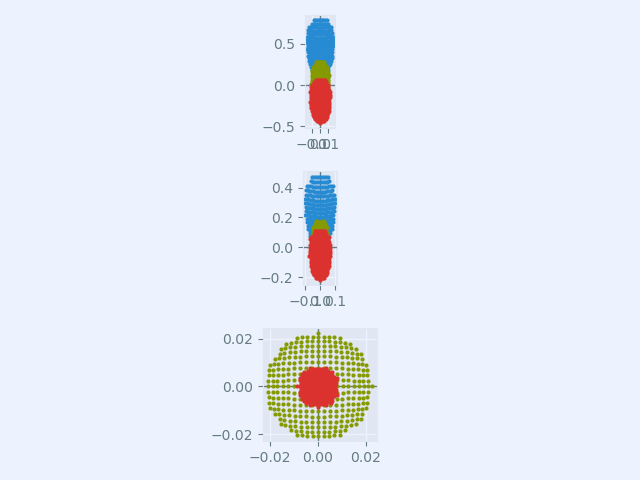

In [25]:
opm.seq_model.gaps[-1].thi = get_focus(sm)
opm.update_model()

#spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, scale_type=Fit.User_Scale,
#                      user_scale_value=0.1, is_dark=isdark).plot()T
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()
spot_rms(sm, 0), spot_rms(sm, 1), spot_rms(sm, 2)

In [ ]:
import numpy as np

def get_focus_val(sm, nflds=3, weights=np.array([0.25, 0.5, 0.25]), fld_weights=np.array([0.6, 0.2, 0.2])):
    offsets = np.linspace(-40, 40, 2000)
    valss = []
    try:
        for i in range(nflds):
            vals, colors = sm.trace_grid(dump_rays, i, form='list', append_if_none=False)
            valss.append(vals)

        rms = np.zeros((offsets.size, len(valss)), dtype=float)

        for i in range(offsets.size):
            for j in range(len(valss)):
                for k in range(len(valss[j])):
                    rms[i][j] += fld_weights[j]*np.sqrt(np.mean(np.square(valss[j][k][:,0]+valss[j][k][:,1]*offsets[i])))

        return np.min(np.sum(rms*fld_weights, axis=1))
    except:
        return 1e+9

idxs = [gap0_idx, gap1_idx, gap2_idx]
orig_gaps = [sm.gaps[idx].thi for idx in idxs]

In [26]:
# twiddle with all the gaps and see what happens

from numpy.random import default_rng
rng = default_rng()
offsets = (2*rng.random((1000, 3))-0.5)*np.array([50., 20., 20.])
rms = np.zeros(offsets.shape[0])


for i in range(offsets.shape[0]):
    for j in range(len(idxs)):
        sm.gaps[idxs[j]].thi = orig_gaps[j] + offsets[i][j]
    sm.update_model()
    if i % 100 == 0:
        print("sim {}".format(i))
    rms[i] = get_focus_val(sm)

for i in range(len(idxs)):
    sm.gaps[idxs[i]].thi = orig_gaps[i]
sm.update_model()

offsets[np.argmin(rms)], rms[np.argmin(rms)]

sim 0
sim 100
sim 200
sim 300
sim 400
sim 500
sim 600
sim 700
sim 800
sim 900


(array([-19.73943222,  -0.84497351,  20.18892131]), 0.03587481358868996)

(array([0.00465224, 0.01644699, 0.00241372]),
 array([0.13847349, 0.10443455, 0.11971615]),
 array([0.23461643, 0.22702221, 0.25881069]))

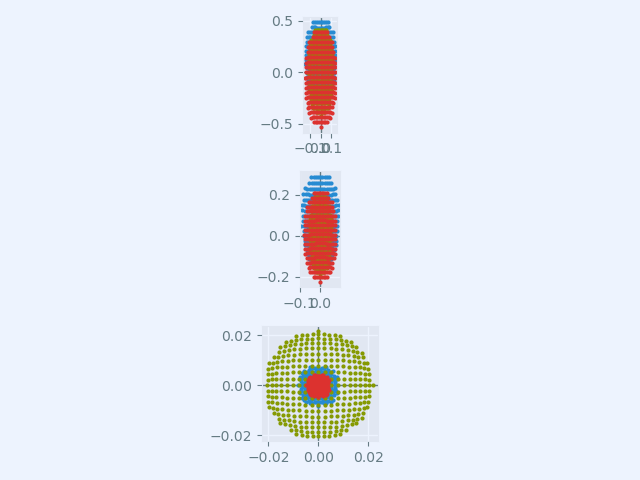

In [27]:
for j in range(len(idxs)):
    sm.gaps[idxs[j]].thi = orig_gaps[j] + offsets[np.argmin(rms)][j]
opm.update_model()
sm.gaps[-1].thi = get_focus(sm)
opm.update_model()

spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm, is_dark=isdark).plot()
spot_rms(sm, 0), spot_rms(sm, 1), spot_rms(sm, 2)

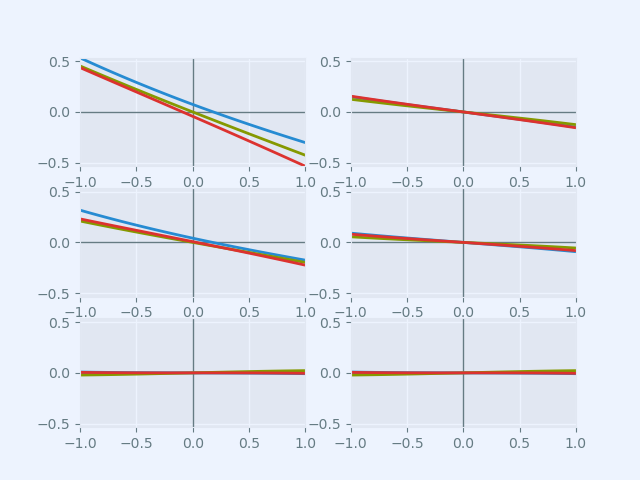

In [28]:
abr_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray',
                     scale_type=Fit.All_Same).plot()

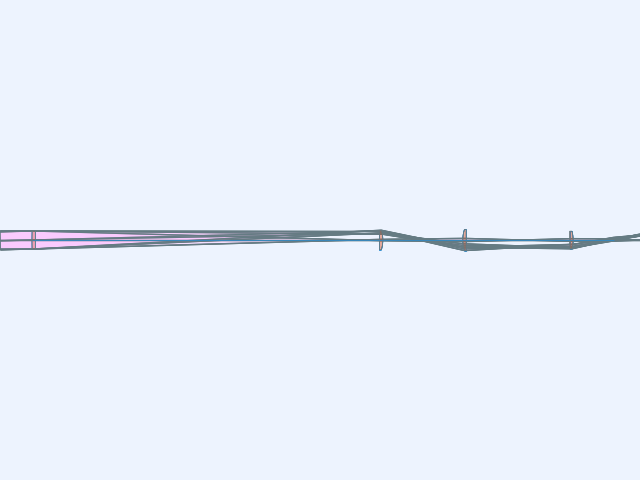

In [29]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark).plot()